# Configuration

In [1]:
# Import libraries
import pandas            as pd
import matplotlib.pyplot as plt
import mplfinance        as mpf
import os                as os

from amberdata_derivatives import AmberdataDerivatives

import warnings
warnings.filterwarnings("ignore")

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Retrieve API key
API_KEY = os.getenv("API_KEY")

# Amberdata SDK

In [2]:
amberdata_client = AmberdataDerivatives(api_key=API_KEY)

amberdata_client.get

# ATM Term Structure Comparison BTC vs. ETH
# ATM Term Structure Comparison BTC Mark vs Forward Curve

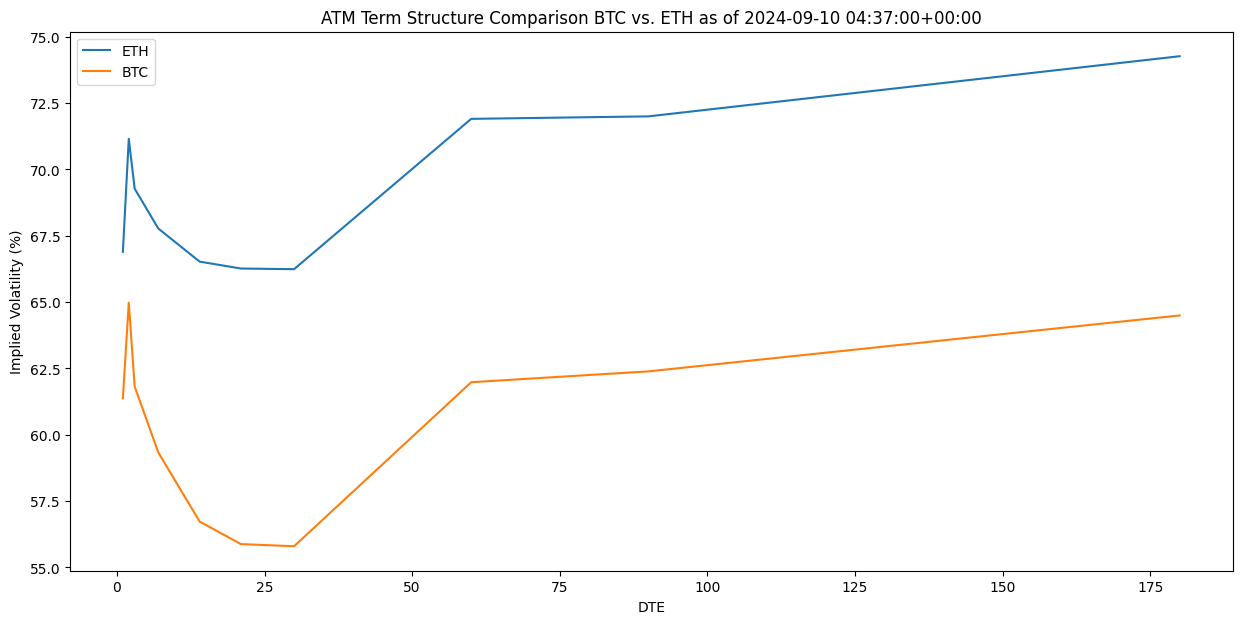

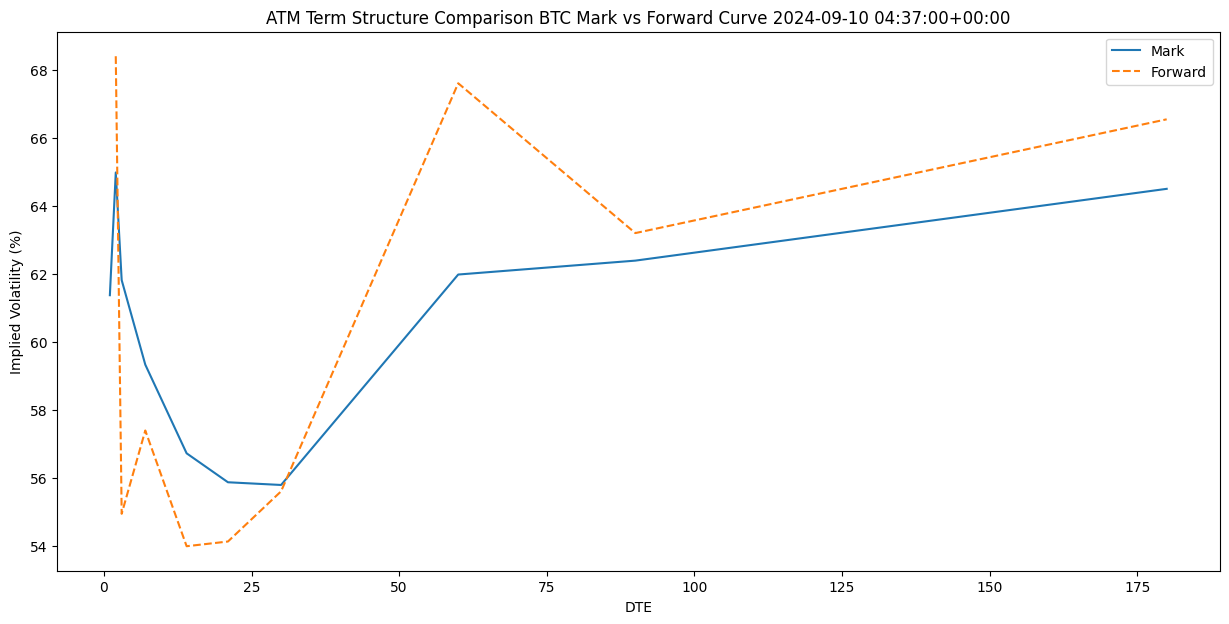

In [3]:
btc = pd.DataFrame(amberdata_client.get_volatility_term_structures_constant(currency='BTC', exchange='deribit')['payload']['data'])
eth = pd.DataFrame(amberdata_client.get_volatility_term_structures_constant(currency='ETH', exchange='deribit')['payload']['data'])

# plot the atm BTC + ETH term structure
plt.figure(figsize=(15, 7))
plt.plot(eth.daysToExpiration, eth.atm, label='ETH')
plt.plot(btc.daysToExpiration, btc.atm, label='BTC')
plt.title("ATM Term Structure Comparison BTC vs. ETH as of " + str(str(pd.to_datetime(btc.timestamp[0]))))
plt.ylabel("Implied Volatility (%)")
plt.xlabel("DTE")
plt.legend()

# plot BTC atm + atm forward vol
plt.figure(figsize=(15, 7))
plt.plot(btc.daysToExpiration, btc.atm, label='Mark')
plt.plot(btc.daysToExpiration, btc.fwdAtm, label='Forward', linestyle='--')
plt.title("ATM Term Structure Comparison BTC Mark vs Forward Curve " + str(str(pd.to_datetime(btc.timestamp[0]))))
plt.ylabel("Implied Volatility (%)")
plt.xlabel("DTE")
plt.legend();

# ATM BTC volatility

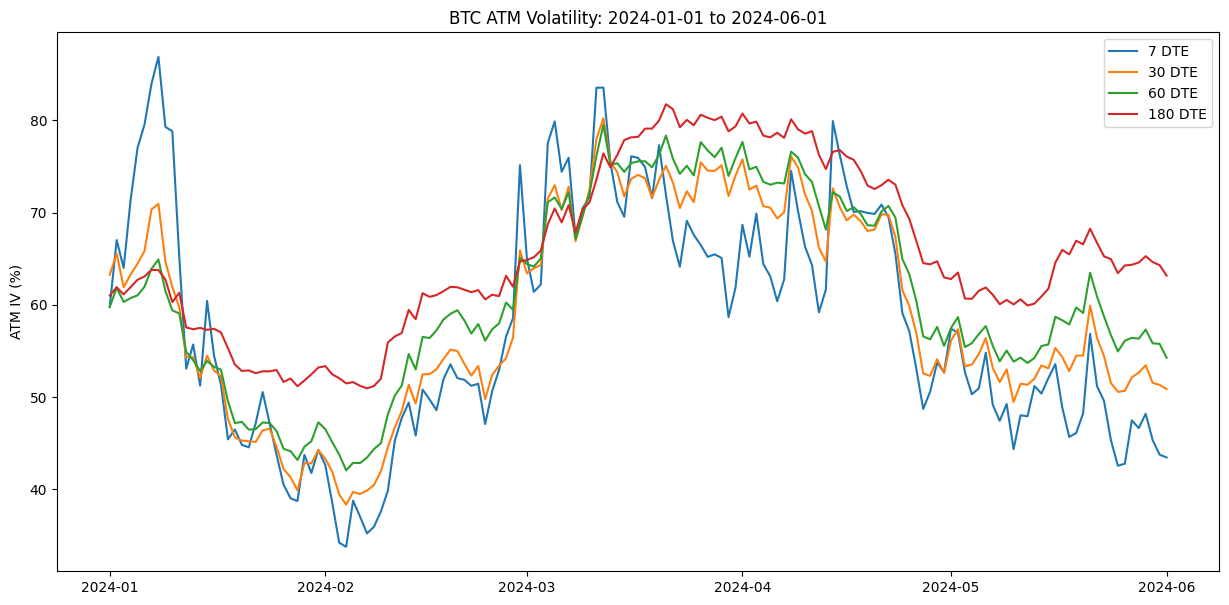

In [4]:
data = amberdata_client.get_volatility_delta_surfaces_constant(currency='BTC', exchange='deribit', startDate='2024-01-01', endDate='2024-06-01', timeInterval='day')
data = data['payload']['data']
data = pd.DataFrame(data)

date = pd.to_datetime(data[data.daysToExpiration==7].timestamp)

plt.figure(figsize=(15, 7))
plt.plot(date, data[data.daysToExpiration==7].atm, label='7 DTE')
plt.plot(date, data[data.daysToExpiration==30].atm, label='30 DTE')
plt.plot(date, data[data.daysToExpiration==60].atm, label='60 DTE')
plt.plot(date, data[data.daysToExpiration==180].atm, label='180 DTE')
plt.legend()
plt.title("BTC ATM Volatility: 2024-01-01 to 2024-06-01")
plt.ylabel("ATM IV (%)");

# BTC ∆25/∆35 Ratio [Call - Put]

Text(0, 0.5, 'Skew [Call - Put] (%)')

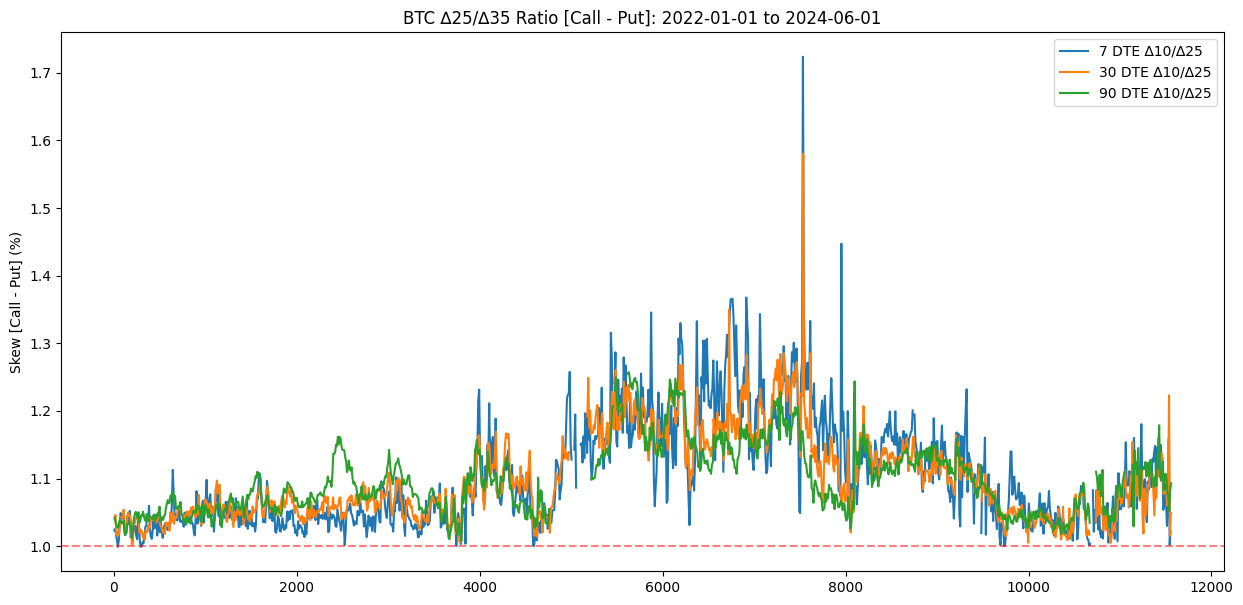

In [5]:
data = amberdata_client.get_volatility_delta_surfaces_constant(currency='BTC', exchange='deribit', startDate='2019-04-01', endDate='2022-06-01', timeInterval='day')
data = data['payload']['data']
data = pd.DataFrame(data)

s7  = data[data.daysToExpiration==7]
s30 = data[data.daysToExpiration==30]
s90 = data[data.daysToExpiration==90]

plt.figure(figsize=(15, 7))
plt.plot(s7.deltaCall10 / s7.deltaCall25, label='7 DTE ∆10/∆25')
plt.plot(s30.deltaCall10 / s30.deltaCall25, label='30 DTE ∆10/∆25')
plt.plot(s90.deltaCall10 / s90.deltaCall25, label='90 DTE ∆10/∆25')
plt.axhline(1, linestyle='--', c='r', alpha=0.50)
plt.legend()
plt.title("BTC ∆25/∆35 Ratio [Call - Put]: 2022-01-01 to 2024-06-01")
plt.ylabel("Skew [Call - Put] (%)")

# BTC Deribit volatility curves 

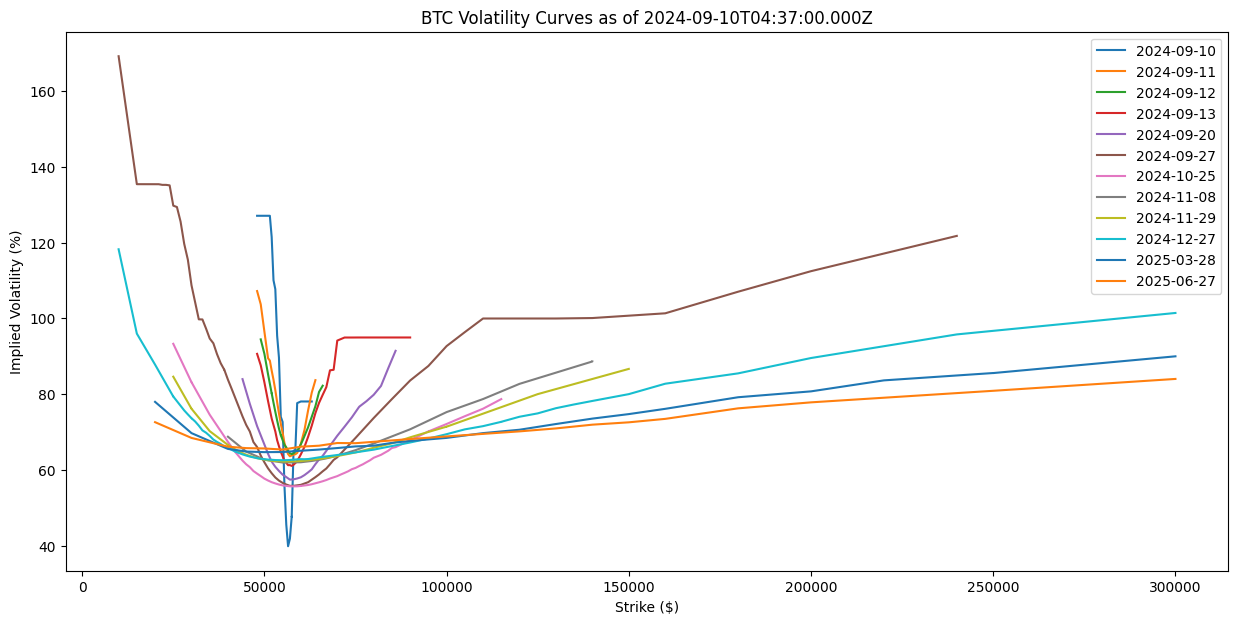

In [6]:
data = pd.DataFrame(amberdata_client.get_volatility_level_1_quotes(exchange='deribit', currency='btc')['payload']['data'])
mats = sorted(set(data.expirationTimestamp))

plt.figure(figsize=(15, 7))
for mat in mats:
    sub = data[data.expirationTimestamp == mat]
    sub = sub.sort_values("strike").reset_index(drop=True)
    
    plt.plot(sub.strike, sub.markIv, label=mat[:10])
    plt.legend()
    plt.title("BTC Volatility Curves as of " + str(data.timestamp[0]))
    plt.ylabel("Implied Volatility (%)")
    plt.xlabel("Strike ($)")

# BTC Term Structure Richness

Text(0, 0.5, 'Term Structure Richness Ratio')

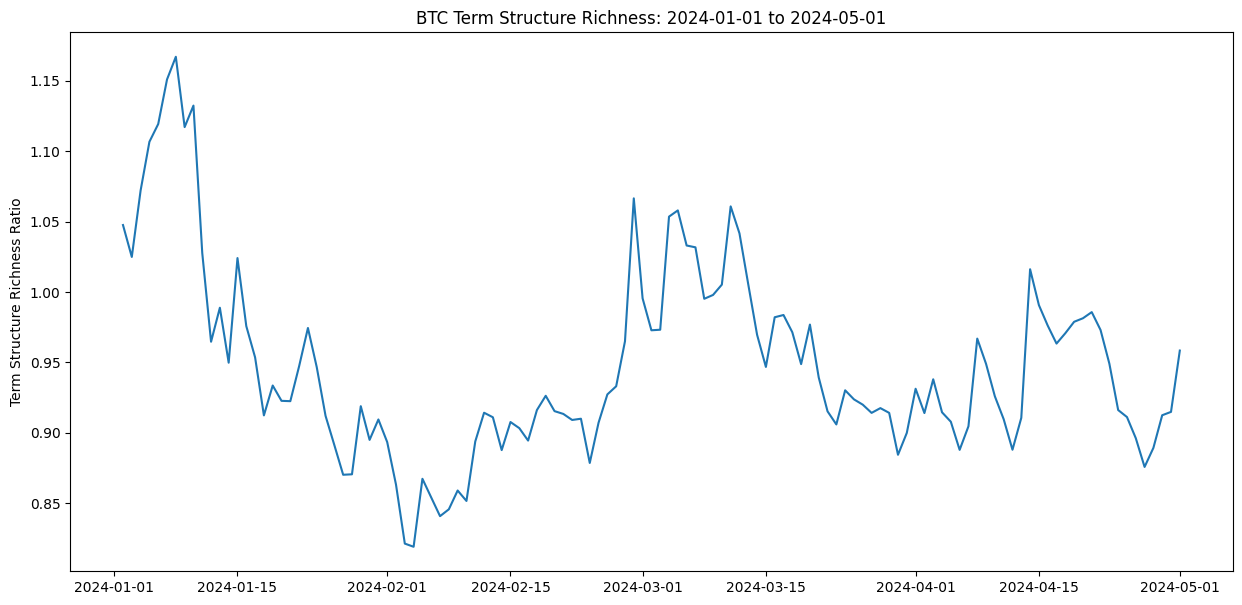

In [7]:
data = amberdata_client.get_volatility_term_structures_richness(exchange='deribit', currency='btc', startDate='2024-01-01', endDate='2024-05-01')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.timestamp)

plt.figure(figsize=(15, 7))
plt.plot(data.richness)
plt.title("BTC Term Structure Richness: 2024-01-01 to 2024-05-01")
plt.ylabel("Term Structure Richness Ratio")

# BTC DVOL 

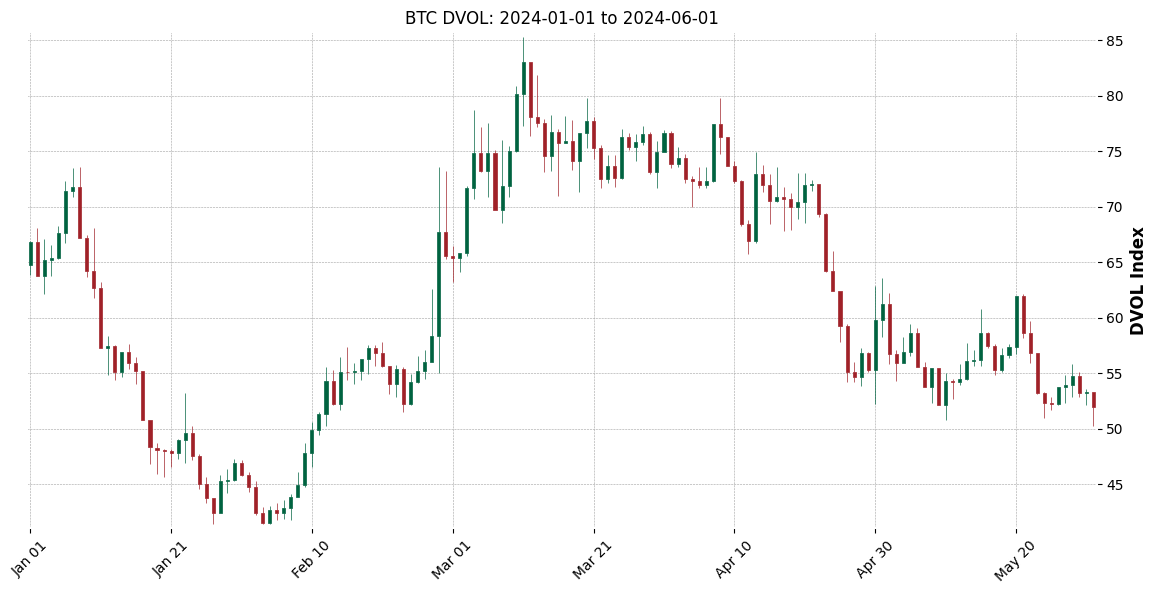

In [8]:
dvol = amberdata_client.get_volatility_index(exchange='deribit', currency='btc', startDate='2024-01-01', endDate='2024-06-01', timeInterval='day')
dvol = pd.DataFrame(dvol['payload']['data'])

dvol.index = pd.to_datetime(dvol.exchangeTimestamp, unit='ms')
dvol = dvol[dvol.currency=='BTC']
dvol = dvol.sort_index()

mpf.plot(dvol, type='candle', style='charles', figratio=(15, 7), 
         ylabel='DVOL Index', axtitle='BTC DVOL: 2024-01-01 to 2024-06-01', tight_layout=True)

# DVOL vs spot and RR vs spot

Text(0, 0.5, 'ATM IV')

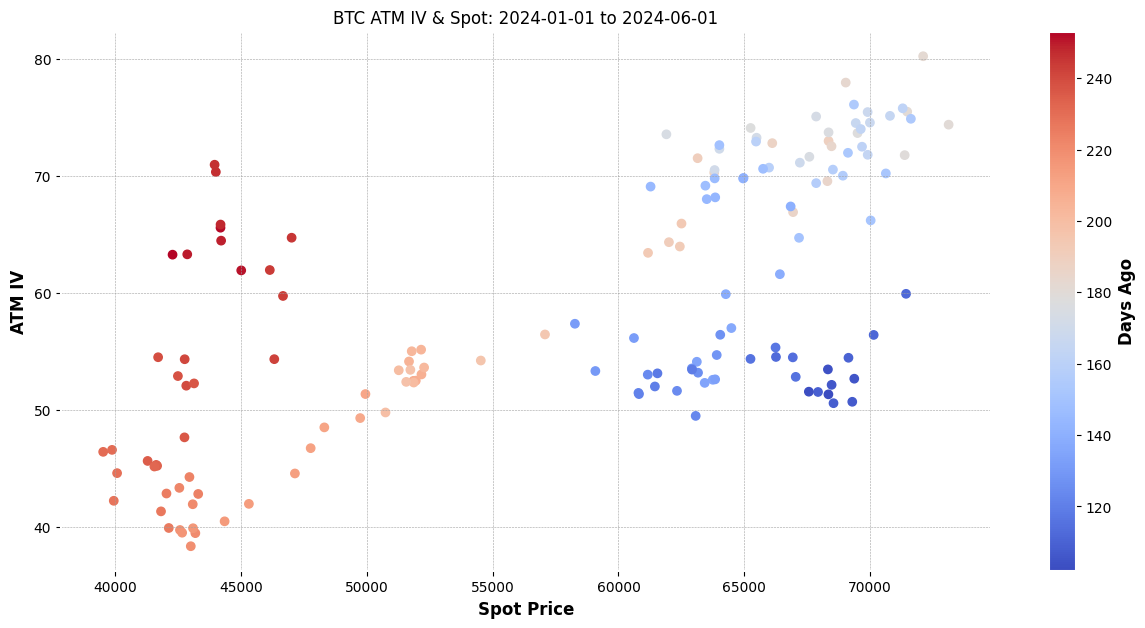

In [9]:
data = amberdata_client.get_volatility_index_decorated(exchange='deribit', currency='btc',  startDate='2024-01-01', endDate='2024-06-01', timeInterval='day')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.exchangeTimestamp, unit='ms')
data = data[data.currency=='BTC']
data = data.sort_index()

plt.figure(figsize=(15, 7))
scatter = plt.scatter(data.indexPrice, data.atm, c=data.daysAgo, cmap='coolwarm')
cbar = plt.colorbar(scatter)
cbar.set_label('Days Ago')
plt.title("BTC ATM IV & Spot: 2024-01-01 to 2024-06-01")
plt.xlabel("Spot Price")
plt.ylabel("ATM IV")

# BTC 25 Delta RR Skew & Spot

Text(0, 0.5, '25 RR Skew')

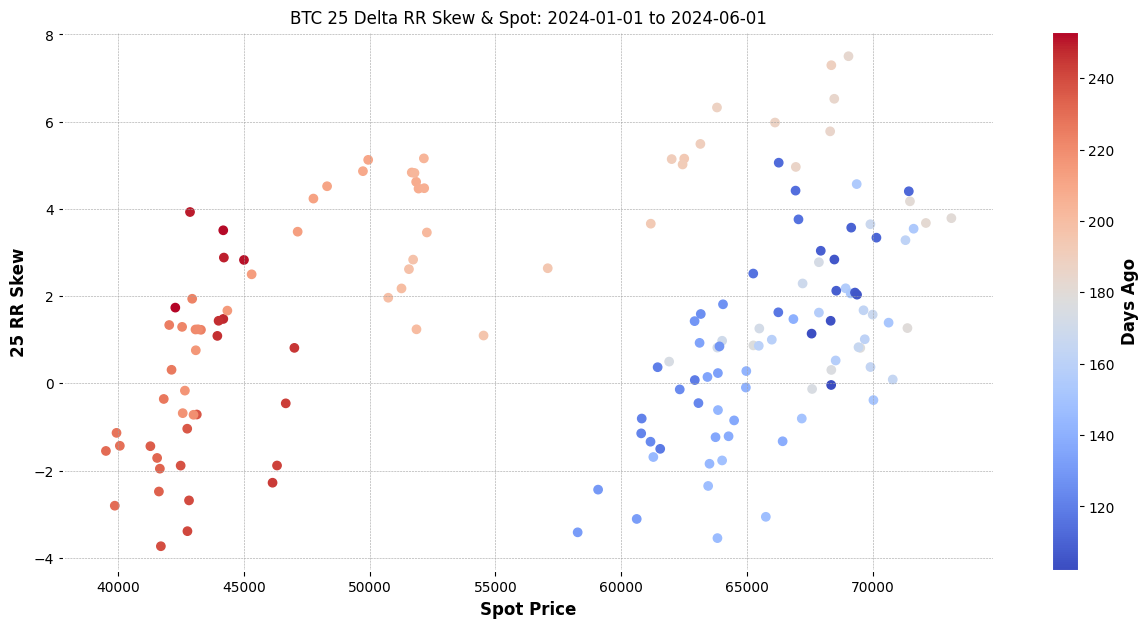

In [10]:
plt.figure(figsize=(15, 7))
scatter = plt.scatter(data.indexPrice, data.delta25RrSkew, c=data.daysAgo, cmap='coolwarm')
cbar = plt.colorbar(scatter)
cbar.set_label('Days Ago')
plt.title("BTC 25 Delta RR Skew & Spot: 2024-01-01 to 2024-06-01")
plt.xlabel("Spot Price")
plt.ylabel("25 RR Skew")

# BTC DVOL / ATM 30 DTE IV

Text(0, 0.5, 'Butterfly Ratio')

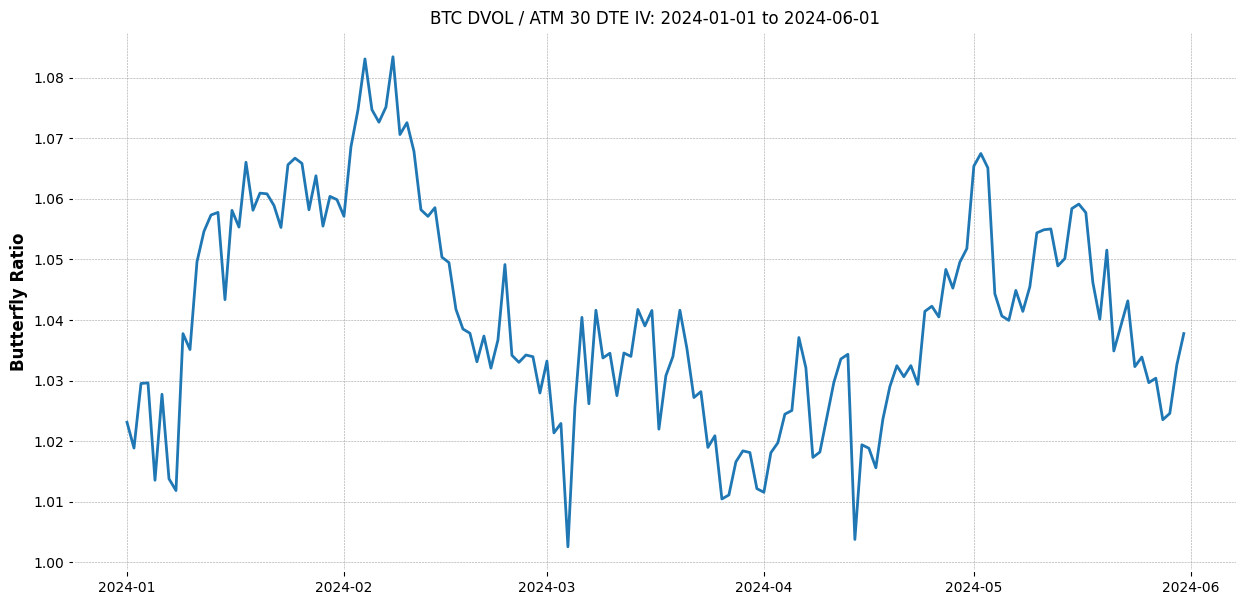

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(data.close/data.atm)
plt.title("BTC DVOL / ATM 30 DTE IV: 2024-01-01 to 2024-06-01")
plt.ylabel("Butterfly Ratio")

# Volatility metrics table

In [12]:
data = amberdata_client.get_volatility_metrics(exchange='deribit', currency='btc', daysBack=7)
data = pd.DataFrame(data['payload']['data'])
data

,exchange,currency,expirationTimestamp,daysToExpiration,underlyingPrice,underlyingPriceChange,riskReversal25,riskReversal25Change,riskReversal15,riskReversal15Change,butterfly25,butterfly25Change,butterfly15,butterfly15Change,atm,atmChange
0,deribit,BTC,1726214400000,3.140972,56484.001795,-2831.470705,-3.185752,-2.427742,-6.013652,-4.782548,4.961853,2.787484,12.586135,6.261374,61.261223,12.385348
1,deribit,BTC,1726819200000,10.140972,56572.202167,-2809.940333,-2.224285,-1.443533,-4.240232,-2.949388,3.708265,1.055016,9.373324,2.023938,57.716217,7.543863
2,deribit,BTC,1727424000000,17.140972,56636.753889,-2813.559514,-1.928463,-1.632692,-3.676415,-2.555094,3.603489,0.898852,9.779447,2.304807,55.913041,5.637538
3,deribit,BTC,1729843200000,45.140972,56956.600093,-2855.523148,-0.141184,-1.256622,-0.573671,-1.935944,3.177311,0.056806,7.870868,0.341908,55.664809,2.440449
4,deribit,BTC,1731052800000,59.140972,57138.777618,-2892.388479,0.995737,-0.629929,1.565826,-0.645290,2.690593,-0.265232,7.206312,-0.178450,61.969942,2.577167
5,deribit,BTC,1732867200000,80.140972,57402.220625,-2958.451697,1.472254,-0.774053,2.226516,-0.508285,2.711176,0.070206,6.595484,0.226645,62.236304,2.273011
6,deribit,BTC,1735286400000,108.140972,57748.500000,-3053.575565,2.090183,-0.556676,2.711748,-0.681423,2.731051,0.039782,6.531909,0.125059,62.669977,1.771908
7,deribit,BTC,1743148800000,199.140972,58918.987600,-3328.970400,3.215889,-0.388587,4.689013,0.023360,2.762734,-0.378630,5.767717,-0.259668,64.976587,1.702503
8,deribit,BTC,1751011200000,290.140972,60184.690833,-3506.375000,3.876241,-0.300186,5.778629,-0.684888,2.984959,-0.599088,6.381757,-0.294332,66.129581,1.235278
